In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, astropy, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2019-04-23 19:40:08 (KST = GMT+0900) 
0 Python     3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    6.5.0
2 OS         Darwin 18.5.0 x86_64 i386 64bit
3 scipy      1.2.1
4 numpy      1.16.2
5 matplotlib 3.0.3
6 astropy    3.1.2
7 photutils  0.6
8 version_information 1.0.3


In [6]:
from pathlib import Path

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Circle

%matplotlib inline
# Remove the line with % if you are not using "Notebook".

plt.style.use('default')
rcParams.update({'font.size':12})

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAnnulus as CAn
from photutils.aperture import CircularAperture as CAp

from photutils.centroids import centroid_com

FIGPATH = Path('..') / "figs"

## 1. Aperture Sum Example

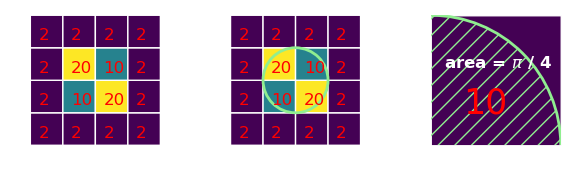

In [7]:
data = np.array([[2, 2, 2, 2],
                 [2, 10, 20, 2],
                 [2, 20, 10, 2],
                 [2, 2, 2, 2]])
fig, axs = plt.subplots(1, 3, figsize=(6, 2))
# axs[0].imshow(data, alpha=0.3, origin='lower')

for ax in axs.tolist()[:-1]:
    ax.pcolor(data, edgecolors='w', linewidths=1)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j+0.25, i+0.25, data[i, j], color='r')

aperture = Circle(xy=(2, 2), radius=1, facecolor='none', edgecolor='lightgreen', linewidth=2)
axs[1].add_artist(aperture)

aperture = Circle(xy=(0, 0), radius=1, facecolor='none', hatch='//', edgecolor='lightgreen', linewidth=2)
axs[2].pcolor(data[1:2, 1:2], edgecolors='w', linewidths=1)
axs[2].add_artist(aperture)
axs[2].text(0.1, 0.6, r"area = $\pi$ / 4", color='w', fontweight='bold')
axs[2].text(0.25, 0.25, r"10", color='r', fontsize=25)
            
for ax in axs.tolist():
    ax.axis('off')
    ax.set_aspect('equal')


plt.tight_layout()
plt.savefig(FIGPATH / "phot_ap_ex01.png")

* **NOTE**: I used ``pcolor`` above to put the white grid lines easier thatn ``imshow``. _But be careful! The ``pcolor`` renders data by 0.5 pixel shifted as shown below_. 
* **TIP**: I recommend to always use ``imshow``...

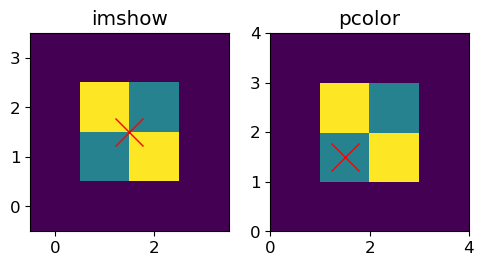

In [8]:
cent = centroid_com(data)

fig, axs = plt.subplots(1, 2, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
axs[0].imshow(data, origin='lower')
axs[0].set_title("imshow")
axs[1].pcolor(data)
axs[1].set_title("pcolor")

for ax in axs.tolist():
    ax.plot(*cent, marker='x', ms=20, color='r')
#     ax.axis('off')
    ax.set_aspect('equal')


plt.tight_layout()

## 2. Circular Annulus Sky Example

Below, I used
* [``astropy.stats.sigma_clipped_stats``](http://docs.astropy.org/en/stable/api/astropy.stats.sigma_clipped_stats.html)
* [``photutils.centroid``](https://photutils.readthedocs.io/en/stable/centroids.html)
  * I used [``centroid_com``](https://photutils.readthedocs.io/en/stable/api/photutils.centroids.centroid_com.html#photutils.centroids.centroid_com) after masking pixels with sigma-clipping.
* [``photutils.aperture``](https://photutils.readthedocs.io/en/stable/aperture.html)
  * Read the annulus analysis part in the link, i.e., [here](https://photutils.readthedocs.io/en/stable/aperture.html#sigma-clipped-median-within-a-circular-annulus)

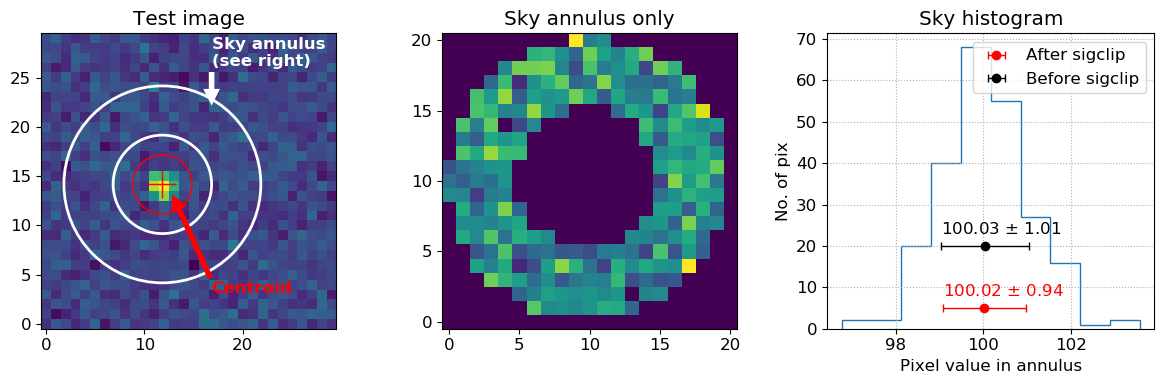

In [9]:
np.random.seed(123)
data = 100 + np.random.normal(size=(30,30))
data[13:16, 11:14] += np.array([[5, 10, 5], [9, 12, 8], [6, 9, 5]])

_, msky, ssky = sigma_clipped_stats(data, sigma=3, maxiters=50, std_ddof=1)
bkgmask = data < (msky + 5 * ssky)
cent = centroid_com(data, mask=bkgmask)

ap = CAp(positions=cent, r=3)
an = CAn(positions=cent, r_in=5, r_out=10)

issky      = an.to_mask(method='center')
# ``method`` can also be 'exact' but that is unnecessary for sky estimation.
# Try that and see the explanation in photutils:
#    https://photutils.readthedocs.io/en/stable/aperture.html#sigma-clipped-median-within-a-circular-annulus
skyvals    = issky[0].multiply(data)
skyvals_1d = skyvals[issky[0].data > 0]

_, msky, ssky   = sigma_clipped_stats(skyvals_1d, sigma=3, maxiters=5, std_ddof=1)
msky_0 , ssky_0 = np.median(skyvals_1d), np.std(skyvals_1d, ddof=1)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'width_ratios':[1,1,1.]})

axs[0].imshow(data, origin='lower')
axs[0].plot(*cent, 'r+', ms=20)
ap.plot(ax=axs[0], color='r', lw=1)
an.plot(ax=axs[0], color='w', lw=2)
axs[0].annotate('Sky annulus\n(see right)', xy=cent + [5, 8], xytext=cent + [5, 12], color='w',
                arrowprops=dict(facecolor='w', edgecolor='none'), fontweight='bold')
# axs[0].imshow(bkgmask, alpha=0.6)
axs[0].annotate("Centroid", xy=cent + [1, -1], xytext=cent + [5, -11], color='r',
               arrowprops=dict(facecolor='r', edgecolor='none'), fontweight='bold')
axs[0].set_title("Test image")

axs[1].imshow(skyvals, vmin=msky - 3 * ssky, vmax = msky + 3 * ssky, origin='lower')
axs[1].set_title("Sky annulus only")

axs[2].hist(skyvals_1d, histtype='step')
axs[2].set_ylabel("No. of pix")
axs[2].set_xlabel("Pixel value in annulus")
axs[2].grid(ls=':')
axs[2].errorbar(msky  ,  5, xerr=ssky  , ls='', capsize=3, elinewidth=1, 
                color='r', marker='o', label="After sigclip")
axs[2].errorbar(msky_0, 20, xerr=ssky_0, ls='', capsize=3, elinewidth=1, 
                color='k', marker='o', label="Before sigclip")
axs[2].text(msky   - ssky  ,  8, r"{:.2f} $ \pm $ {:.2f}".format(msky, ssky)    , color='r')
axs[2].text(msky_0 - ssky_0, 23, r"{:.2f} $ \pm $ {:.2f}".format(msky_0, ssky_0), color='k')
axs[2].legend()
axs[2].set_title("Sky histogram")

for ax in axs.tolist()[:-1]:
#     ax.axis('off')
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(FIGPATH / "phot_ap_ex02.png")

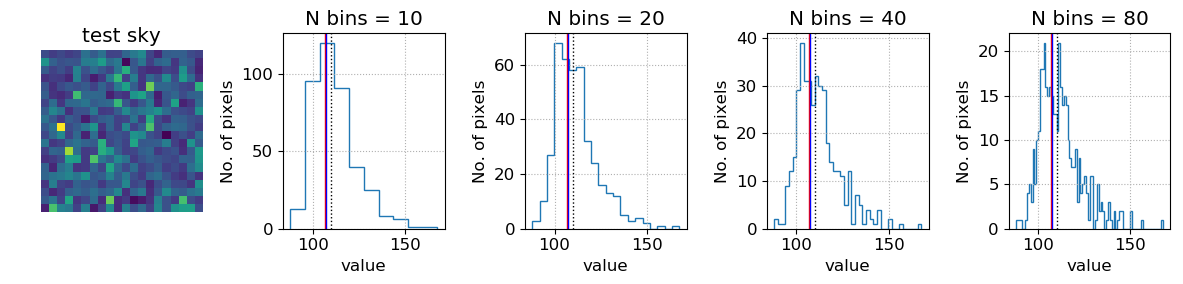

In [10]:
np.random.seed(123)
data = 100 
size = (20, 20)
data += 1 * np.random.normal(loc=0, scale=5, size=size) 
data += 5 * np.random.chisquare(df=2, size=size)
data += 3 * np.random.rand(*size) 
data_1d = data.ravel()

nbins = [10, 20, 40, 80]
fig, axs = plt.subplots(1, 5, figsize=(12, 3))

for i, ax in enumerate(axs.tolist()[1:]):
    ax.grid(which='major', ls=':')
    ax.set_xlabel("value")
    ax.set_ylabel("No. of pixels")
    ax.set_title(f"N bins = {nbins[i]}")
    ax.hist(data_1d, histtype='step', bins=nbins[i])
    ax.axvline(np.median(data_1d), lw=1, color='k', ls=':')
    ax.axvline(3 * np.median(data_1d) - 2 * np.mean(data_1d), lw=1, color='r', ls='-')
    ax.axvline(2.5 * np.median(data_1d) - 1.5 * np.mean(data_1d), lw=1, color='b', ls='-')

#     ax.set_xlim(100, 150)

axs[0].imshow(data, origin='lower')
axs[0].set_title("test sky")
axs[0].axis('off')


plt.tight_layout()
plt.savefig(FIGPATH / "phot_testsky01.png")

GAINDL                         / Pixel integration time, in sequencer clocks     [astropy.io.fits.card]
PIXITIME                       / Pixel integration time, in seconds              [astropy.io.fits.card]
TSHSHUT                        / Master IC reportsshutter close time             [astropy.io.fits.card]
CHOP                           / Chiller Cooling On or Off                       [astropy.io.fits.card]
CHSET                          / Chiller Set Point Temperature in degrees C      [astropy.io.fits.card]
CHPROC                         / Chiller Protection Temperature in degrees C     [astropy.io.fits.card]
RTD12                                                                            [astropy.io.fits.card]


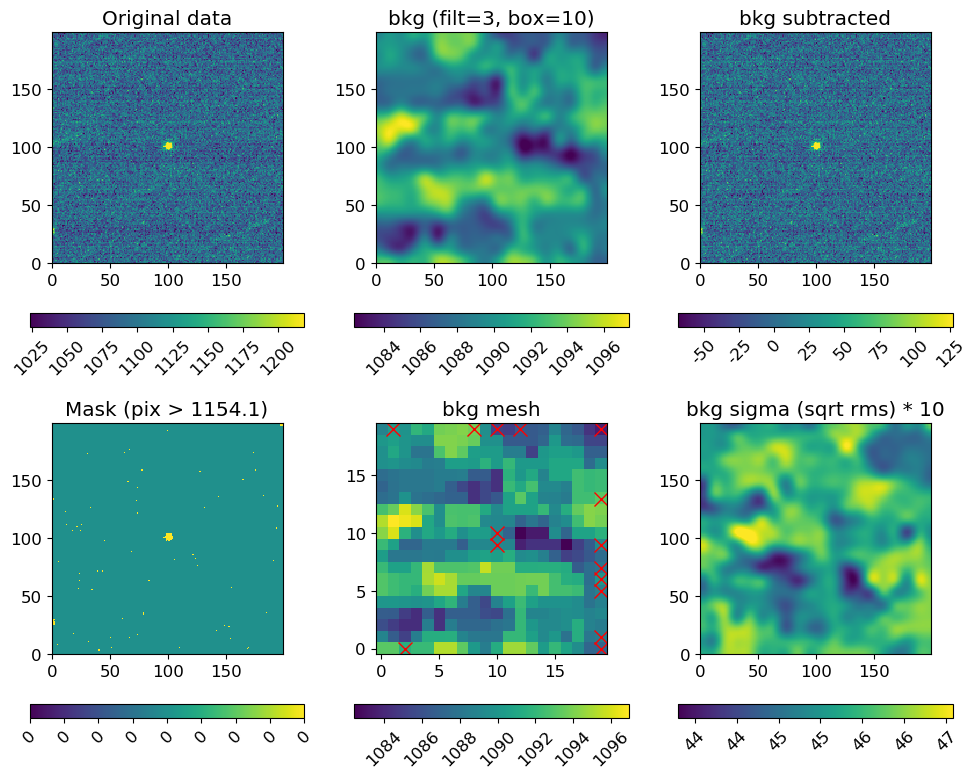

In [104]:
from photutils import Background2D
from astropy.stats import SigmaClip
from astropy.visualization import ZScaleInterval, ImageNormalize

def colorbaring(fig, ax, im):
    cb = fig.colorbar(im, ax=ax, orientation='horizontal')
    cb.ax.set_xticklabels(cb.get_ticks().astype(int), rotation=45)


def znorm(image):
    return ImageNormalize(image, interval=ZScaleInterval())


def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image), origin='lower', **kwargs)

    
box = 10
filt = 3
mask_size = 6

fpath = Path("data") / "20180413SAAO_targ.fits"
bkg_path = fpath.parent / (fpath.name[:-5] + '_bkg.png')
png_path = fpath.parent / (fpath.name[:-5] + '.png')
hdu = fits.open(fpath)[0]
data = hdu.data
cent_x, cent_y = np.array(data.shape) - 0.5

mask = np.zeros_like(data).astype(bool)
xmin = np.around(cent_x - mask_size / 2).astype(int)
xmax = np.around(cent_x + mask_size / 2).astype(int)
ymin = np.around(cent_y - mask_size / 2).astype(int)
ymax = np.around(cent_y + mask_size / 2).astype(int)
mask[ymin:ymax, xmin:xmax] = True

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=5)
thresh = med + 3 * std
possible_src = (data > thresh)
mask = np.logical_or(mask, possible_src)
# SEx not necessarily subtract only the sky but can also subtract 
# starlights in this code. I intended to do so.
bkg_sex = Background2D(data, 
                       box_size=box, 
                       mask=mask,
                       filter_size=filt, 
                       sigma_clip=SigmaClip(sigma=3, maxiters=5))
skysub = data - bkg_sex.background

fig, axs = plt.subplots(2, 3, figsize=(10, 8))

im1 = zimshow(axs[0,0], data)
colorbaring(fig, axs[0,0], im1)

im2 = zimshow(axs[0,1], bkg_sex.background)
colorbaring(fig, axs[0,1], im2)

im3 = zimshow(axs[0,2], skysub)
colorbaring(fig, axs[0,2], im3)

im4 = zimshow(axs[1,0], mask)
colorbaring(fig, axs[1,0], im4)

im5 = zimshow(axs[1,1], bkg_sex.background_mesh)
axs[1, 1].plot(*np.where(bkg_sex.background_mesh_ma.mask==True), 'rx', ms=10)
colorbaring(fig, axs[1,1], im5)

im6 = zimshow(axs[1,2], 10 * np.sqrt(bkg_sex.background_rms))
colorbaring(fig, axs[1,2], im6)


axs[0,0].set_title("Original data")
axs[0,1].set_title(f"bkg (filt={filt:d}, box={box:d})")
axs[0,2].set_title("bkg subtracted")
axs[1,0].set_title(f"Mask (pix > {thresh:.1f})")
axs[1,1].set_title("bkg mesh")
axs[1,2].set_title("bkg sigma (sqrt rms) * 10")

plt.tight_layout()
plt.savefig(FIGPATH / "sex_bkg_01.png")
# plt.close('all')



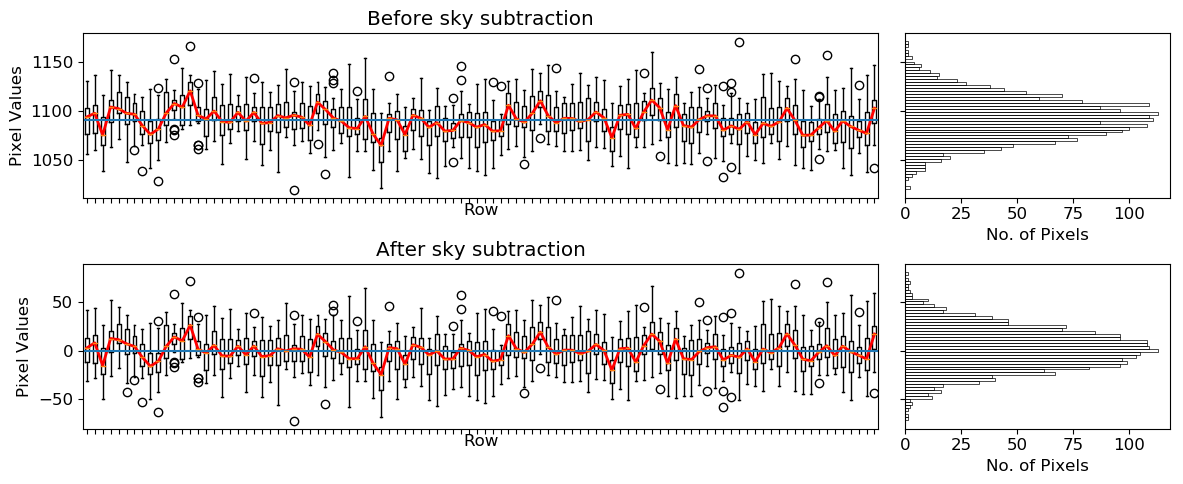

In [111]:
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=False, sharey='row', 
                        gridspec_kw={'width_ratios':[3,1]})

col_orig = data[50:150, 70:90]
col_subt = skysub[50:150, 70:90]

axs[0,0].boxplot(col_orig.T)
axs[0,0].tick_params(labelbottom=False)
axs[0,0].plot(1 + np.arange(col_orig.shape[0]), np.median(col_orig, axis=1), 'r-', lw=2)
axs[0,0].axhline(np.median(col_orig))
axs[0,0].set_title("Before sky subtraction")
axs[0,0].set_xlabel("Row")
axs[0,0].set_ylabel("Pixel Values")


axs[1,0].boxplot(col_subt.T)
axs[1,0].tick_params(labelbottom=False)
axs[1,0].plot(1 + np.arange(col_subt.shape[0]), np.median(col_subt, axis=1), 'r-', lw=2)
axs[1,0].axhline(np.median(col_subt))
axs[1,0].set_title("After sky subtraction")
axs[1,0].set_xlabel("Row")
axs[1,0].set_ylabel("Pixel Values")


# axs[2,0].plot(np.median(col_orig, axis=1) - np.median(col_orig), label="Before subtraction")
# axs[2,0].plot(np.median(col_subt, axis=1) - np.median(col_subt), label="After subtraction")
# axs[2,0].plot(col_orig.ravel() - np.median(col_orig), label="Before subtraction")
# axs[2,0].plot(col_subt.ravel() - np.median(col_subt), label="After subtraction")
# axs[2,0].legend()


hist, bin_edges = np.histogram(col_orig, bins=50)
bar_cents = bin_edges[:-1] + np.ediff1d(bin_edges)
height = np.ediff1d(bin_edges)[0]
axs[0, 1].barh(bar_cents, hist, height=height, color='none', edgecolor='k', lw=0.5)
axs[0, 1].set_xlabel("No. of Pixels")

hist, bin_edges = np.histogram(col_subt, bins=50)
bar_cents = bin_edges[:-1] + np.ediff1d(bin_edges)
height = np.ediff1d(bin_edges)[0]
axs[1, 1].barh(bar_cents, hist, height=height, color='none', edgecolor='k', lw=0.5)
axs[1, 1].set_xlabel("No. of Pixels")



plt.tight_layout()
plt.savefig(FIGPATH / "sex_bkg_02_skyhist.png")

